<a href="https://colab.research.google.com/github/theostoican/MastersThesis/blob/main/training_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import copy
import csv
import torch.nn as nn
import numpy as np
import torch
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib

!pip install dict_minimize
from dict_minimize.torch_api import minimize
from collections import OrderedDict

# Various modelling parameters

In [17]:
#N is batch size; D_in is input dimension;
#H is the dimension of the hidden layer; D_out is output dimension.
N, D_in, H_teacher, H_student, D_out = 1, 2, 4, 5, 1
num_experiments = 1

# Dataset creation

In [18]:
def construct_dataset():
  data = []
  for y in np.arange(-5, 5.1, .25):
    for x in np.arange(-5, 5.1, .25):
      data.append([x, y])
  return data

data = torch.Tensor(construct_dataset()) 
print(len(construct_dataset()))

1681


# Models

In [19]:
class TeacherNetwork(nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(TeacherNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False) 
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(torch.transpose(torch.Tensor([[0.6, -0.5, -0.2, 0.1], [0.5, 0.5, -0.6, -0.6]]), 0, 1))
    self.linear2.weight = torch.nn.Parameter(torch.transpose(torch.Tensor([[1], [-1], [1], [-1]]), 0, 1))
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

In [20]:
class StudentNetwork(nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(StudentNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False) 
    self.linear2 = nn.Linear(H, D_out, bias=False)
    nn.init.xavier_uniform_(self.linear1.weight)
    nn.init.xavier_uniform_(self.linear2.weight)
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

# Generation of the labels based on the teacher model.

In [21]:
teacher_model = TeacherNetwork(D_in, H_teacher, D_out)
y_labels = teacher_model(data).detach()

# Training helper method

In [22]:
def train(model, x, y_labels, N = 1000, Ninner = 10**3, Nstart = 10,
          maxtime = 10 ** 3, nlopt_threshold = 1e-7,
          collect_history = True):
  optimizer = torch.optim.Adam(model.parameters()) #, lr=0.0001)
  loss_fn = nn.MSELoss()
  loss_vals = []
  trace = []
  if collect_history:
    trace.append((copy.deepcopy(model.linear1.weight.data.detach().numpy()),
                  copy.deepcopy(model.linear2.weight.data.detach().numpy())))
  for i in range(N):
    loss_tmp = []
    for j in range(Ninner):
      y = model(x)
      loss = loss_fn(y, y_labels)
      loss_grad = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
      loss_tmp.append(loss.item())
      optimizer.zero_grad()
      loss.backward(retain_graph=True)
      optimizer.step()
      if i == 0 and (j % Nstart == 0) and j > 0:
        loss_vals.append(np.mean(loss_tmp[j - Nstart : j]))
        if collect_history:
          trace.append((copy.deepcopy(model.linear1.weight.data.detach().numpy()),
                        copy.deepcopy(model.linear2.weight.data.detach().numpy())))
    loss_vals.append(np.mean(loss_tmp))
    if collect_history:
      trace.append((copy.deepcopy(model.linear1.weight.data.detach().numpy()),
                    copy.deepcopy(model.linear2.weight.data.detach().numpy())))
    # stopping criterion
    cnt = 0
    for g in loss_grad:
        g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector, g.contiguous().view(-1)])
        cnt = 1
    print("Iteration: %d, loss: %s, gradient norm: %s" % (Ninner * i, np.mean(loss_tmp), torch.norm(g_vector)))
    if torch.norm(g_vector) <= 2e-6:
      break
  return loss_vals, trace

# Hessian evaluation helper

In [23]:
def eval_hessian(loss_grad, model):
    cnt = 0
    for g in loss_grad:
        g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector, g.contiguous().view(-1)])
        cnt = 1
    grad_norm = torch.norm(g_vector)
    l = g_vector.size(0)
    hessian = torch.zeros(l, l)
    for idx in range(l):
        grad2rd = torch.autograd.grad(g_vector[idx], model.parameters(), create_graph=True)
        cnt = 0
        for g in grad2rd: 
            g2 = g.contiguous().view(-1) if cnt == 0 else torch.cat([g2, g.contiguous().view(-1)])
            cnt = 1
        hessian[idx] = g2
    hessian[:, idx] = g2
    return grad_norm.cpu().data.numpy(), hessian.cpu().data.numpy()

# Actual training and hessian computation

In [24]:
student_model = StudentNetwork(D_in, H_student, D_out)
loss_vals, trace = train(student_model, data, y_labels)
last_loss_val = loss_vals[-1]

loss_grad = torch.autograd.grad(nn.MSELoss()(student_model(data), y_labels), student_model.parameters(), create_graph=True)
grad_norm, hessian = eval_hessian(loss_grad, student_model)
smallest_eigenvalue = np.min(np.linalg.eigvals(hessian))

print('smallest eigenvalue: ', smallest_eigenvalue)

Iteration: 0, loss: 0.03345492475561332, gradient norm: tensor(0.0066)
Iteration: 1000, loss: 0.0008598318077856675, gradient norm: tensor(0.0028)
Iteration: 2000, loss: 0.00035909458450623786, gradient norm: tensor(0.0011)
Iteration: 3000, loss: 0.0002629026825306937, gradient norm: tensor(0.0007)
Iteration: 4000, loss: 0.00023224779403244612, gradient norm: tensor(0.0005)
Iteration: 5000, loss: 0.0002025335907092085, gradient norm: tensor(0.0004)
Iteration: 6000, loss: 0.0001730091286735842, gradient norm: tensor(0.0003)
Iteration: 7000, loss: 0.00014120709798589814, gradient norm: tensor(0.0002)
Iteration: 8000, loss: 0.00011983784068434034, gradient norm: tensor(3.7106e-05)
Iteration: 9000, loss: 0.00011608801779948407, gradient norm: tensor(3.0726e-05)
Iteration: 10000, loss: 0.00011109463268803665, gradient norm: tensor(4.6454e-05)
Iteration: 11000, loss: 0.00010254112136317417, gradient norm: tensor(4.7536e-05)
Iteration: 12000, loss: 8.330993527670217e-05, gradient norm: tensor

# Plotting

In [25]:
teacher_neurons_x = [0.6, -0.5, -0.2, 0.1]
teacher_neurons_y = [0.5, 0.5, -0.6, -0.6]

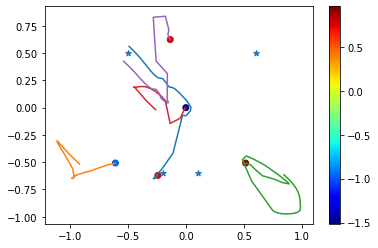

In [26]:

neuron_0_w_x = []
neuron_0_w_y = []
neuron_0_a = []

neuron_1_w_x = []
neuron_1_w_y = []
neuron_1_a = []

neuron_2_w_x = []
neuron_2_w_y = []
neuron_2_a = []

neuron_3_w_x = []
neuron_3_w_y = []
neuron_3_a = []

neuron_4_w_x = []
neuron_4_w_y = []
neuron_4_a = []

for (inp_weights, out_weights) in trace:
  neuron_0_w_x.append(inp_weights[0][0])
  neuron_0_w_y.append(inp_weights[0][1])
  neuron_0_a.append(out_weights[0][0])

  neuron_1_w_x.append(inp_weights[1][0])
  neuron_1_w_y.append(inp_weights[1][1])
  neuron_1_a.append(out_weights[0][1])

  neuron_2_w_x.append(inp_weights[2][0])
  neuron_2_w_y.append(inp_weights[2][1])
  neuron_2_a.append(out_weights[0][2])

  neuron_3_w_x.append(inp_weights[3][0])
  neuron_3_w_y.append(inp_weights[3][1])
  neuron_3_a.append(out_weights[0][3])

  neuron_4_w_x.append(inp_weights[4][0])
  neuron_4_w_y.append(inp_weights[4][1])
  neuron_4_a.append(out_weights[0][4])

plt.plot(neuron_0_w_x, neuron_0_w_y)
plt.plot(neuron_1_w_x, neuron_1_w_y)
plt.plot(neuron_2_w_x, neuron_2_w_y)
plt.plot(neuron_3_w_x, neuron_3_w_y)
plt.plot(neuron_4_w_x, neuron_4_w_y)

plt.scatter(teacher_neurons_x, teacher_neurons_y, marker="*")

outgoing_weights = [neuron_0_a[-1], neuron_1_a[-1], neuron_2_a[-1], neuron_3_a[-1], neuron_4_a[-1]]
plt.scatter([neuron_0_w_x[-1], neuron_1_w_x[-1], neuron_2_w_x[-1], neuron_3_w_x[-1], neuron_4_w_x[-1]],
            [neuron_0_w_y[-1], neuron_1_w_y[-1], neuron_2_w_y[-1], neuron_3_w_y[-1], neuron_4_w_y[-1]],
            c = outgoing_weights,
            cmap=matplotlib.cm.jet)
plt.colorbar()

# Teacher's neurons
#[0.6, -0.5, -0.2, 0.1],
#[0.5, 0.5, -0.6, -0.6],

# Second order optimization

In [27]:
class DummyNetwork(nn.Module):
  def __init__(self, D_in, H, D_out, w_in, w_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(DummyNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False) 
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(w_in)
    self.linear2.weight = torch.nn.Parameter(w_out)
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

In [28]:
def d_loss(params):
  w_in, w_out = params["w_in"], params["w_out"]
  dummy_model = DummyNetwork(D_in, H_student, D_out, w_in, w_out)
  obj = nn.MSELoss()(dummy_model(data), y_labels)
  dw_in, dw_out = torch.autograd.grad(obj, dummy_model.parameters())
  d_obj = OrderedDict([("w_in", dw_in), ("w_out", dw_out)])
  return obj, d_obj

In [34]:
params = OrderedDict([("w_in", torch.Tensor(trace[-1][0])), ("w_out", torch.Tensor(trace[-1][1]))])
lb_dict = OrderedDict([("w_in", torch.Tensor(trace[-1][0] - 1)), ("w_out", torch.Tensor(trace[-1][1] - 1))])
ub_dict = OrderedDict([("w_in", torch.Tensor(trace[-1][0] + 1)), ("w_out", torch.Tensor(trace[-1][1] + 1))])
print('old params: ',params)
# params = minimize(d_loss, params, method="", lb_dict = lb_dict, ub_dict = ub_dict,
#                   options={"disp": True , "maxiter": 10 ** 3}, tol=1e-8)
params = minimize(d_loss, params, method="SLSQP", lb_dict = lb_dict, ub_dict = ub_dict,
                  options={"disp": True , "maxiter": 10 ** 4}, tol=1e-40)
print('new params: ',params)

old params:  OrderedDict([('w_in', tensor([[-2.4470e-01, -6.2086e-01],
        [-6.1159e-01, -5.0734e-01],
        [ 5.1418e-01, -5.0806e-01],
        [-2.8453e-03, -1.9095e-04],
        [-1.3787e-01,  6.2348e-01]])), ('w_out', tensor([[ 0.7732, -0.9763,  0.9600, -1.5138,  0.7570]]))])
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.5222880733745114e-07
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
new params:  OrderedDict([('w_in', tensor([[-2.4470e-01, -6.2086e-01],
        [-6.1159e-01, -5.0734e-01],
        [ 5.1418e-01, -5.0806e-01],
        [-2.8453e-03, -1.9095e-04],
        [-1.3787e-01,  6.2348e-01]], requires_grad=True)), ('w_out', tensor([[ 0.7732, -0.9763,  0.9600, -1.5138,  0.7570]], requires_grad=True))])


# New smallest eigenvalue

In [30]:
dummy_model = DummyNetwork(D_in, H_student, D_out, params["w_in"], params["w_out"])
print(nn.MSELoss()(dummy_model(data), y_labels))
loss_grad = torch.autograd.grad(nn.MSELoss()(dummy_model(data), y_labels), dummy_model.parameters(), create_graph=True)
grad_norm, hessian = eval_hessian(loss_grad, dummy_model)
print(hessian)
smallest_eigenvalue = np.min(np.linalg.eigvals(hessian))
print('new smallest eigenvelue:', smallest_eigenvalue)

tensor(1.5223e-07, grad_fn=<MseLossBackward0>)
[[ 2.66191810e-01 -9.68889147e-02 -2.42168635e-01  1.44997969e-01
   1.59882918e-01  2.42555756e-02 -7.12640941e-01  2.01739103e-01
   2.12254941e-01 -1.69030502e-02 -1.97368022e-02 -1.51785880e-01
   1.90139294e-01 -1.31407147e-03 -1.04171313e-01]
 [-9.68889147e-02  1.24728888e-01  1.44997969e-01 -1.96210340e-01
   2.42555719e-02  1.08888745e-01  2.01739103e-01 -4.65421617e-01
  -1.69030484e-02  8.57481584e-02 -1.19125381e-01 -4.17125449e-02
  -1.31749272e-01  3.20505205e-04  1.47695005e-01]
 [-2.42168635e-01  1.44997969e-01  3.05977076e-01 -2.61726409e-01
  -1.16374664e-01  7.95138720e-03  6.78760588e-01 -4.20444369e-01
  -1.52438313e-01  4.53380160e-02 -5.46782464e-02  9.73710790e-02
  -2.11166993e-01  1.22272724e-03  1.54134229e-01]
 [ 1.44997969e-01 -1.96210355e-01 -2.61726409e-01  3.71663243e-01
   7.95138814e-03 -1.33401722e-01 -4.20444369e-01  7.70907760e-01
   4.53380160e-02 -1.13516875e-01  1.89496532e-01  6.03227280e-02
   2.306